## steps
1. Understand the whole picture
   - Quantify final objectives ?
   - What is the current solution (if any) ? Downsides ?
2. Get data
3. explore, visualize data => **insight**
4. prepare data for machine learning algo
5. select model 
6. fine-tune model 
   - Mesure the errors made by the model, with **RMSE** or **MAE**
7. present solution
8.  launch, monitor, maintain system

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("./housing.csv")

In [3]:
display(data.head())
display(data[["ocean_proximity"]].value_counts())
display(data.info())
display(data.describe())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Get the `feel` of the data with histogram

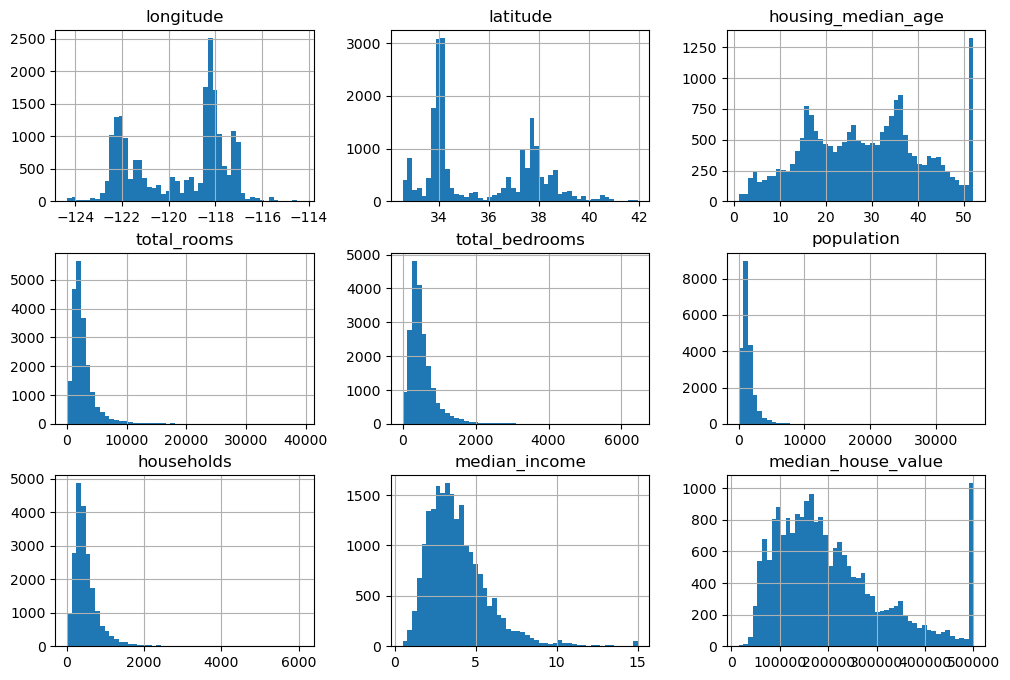

In [4]:
import matplotlib.pyplot as plt

data.hist(bins=50, figsize=(12, 8))
plt.show()

## I. Create `Train/Test` dataset

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# basic dividing
trainset, testset = train_test_split(data,
                                     test_size=.2,
                                     random_state=44)

- But when **data is updated**, and the train and test dataset is **randomly chosen again**  
    => the **new test set** might contain the **old train data**, *thus vice versa*
- **SOLUTION**:
  - **HASH EACH RECORD** (hash so that it produce a **number identifier**)
  - Sort all record based on the **number identifier**
  - divide train/test set at the **PERCENTILE** 

In [7]:
import numpy as np
from zlib import crc32
from typing import Set
def is_id_in_test_set(identifier, test_ratio) -> bool:
    # crc32 create a hash of 32bit check sum
    #  2**32 is the largest number that this algo create
    # test_ratio is the percentile, determine the hash at that percentile 
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column) -> Set[pd.Series]:
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

### 1. Reset the index, use the `index` as identifier

In [8]:
housing_with_id = data.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

### 2. using `longtitude` and `latitude` as identifier 
* not consistent

In [9]:
housing_with_id["new_id"] = data["longitude"] + data["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "new_id")

In [10]:
display(train_set.shape)
display(data.shape)

(20624, 12)

(20640, 10)

## II. divide the data into many `Strata` (`median_income`)
- to investigate if certain groups (*strata*) of people have special statistic
- Each strata (class) will have the same **data distribution**

### 1. Manually create strata

In [11]:
data["income_cat"] = pd.cut(data["median_income"],
                            bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                            labels=[1,2,3,4,5]
                            )

<AxesSubplot:>

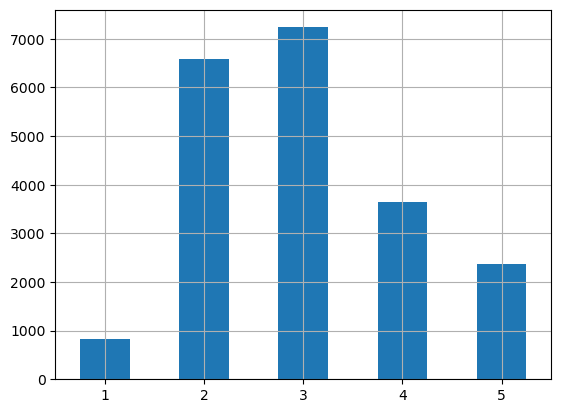

In [12]:
(data["income_cat"] 
 .value_counts()
 .sort_index()
 .plot.bar(rot=0, grid=True)
)

### 2. Create strata with **scikit-learn** 

#### Directly use **StratifiedShuffleSplit** 

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
strat_splits = []
'''
create 10 splits
each split has the same `income_cat` distribution
'''
for train_index, test_index in splitter.split(data, data["income_cat"]):
    print(len(train_index))
    print(len(test_index))
    print("___")
    strat_train_set_n = data.iloc[train_index]
    strat_test_set_n = data.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

16512
4128
___
16512
4128
___
16512
4128
___


#### Use `stratify` option in `train_test_split`  

In [14]:
strat_train_set, strat_test_set = train_test_split(
    data,
    test_size=.2,
    stratify=data["income_cat"],
    random_state=42
)

#### The column `income_cat` is only meant for **stratified sampling**, you can drop it after sampling

In [15]:
strat_test_set.reset_index(drop=True).to_feather("stratified-data/strat_test_set.arrow")
strat_train_set.reset_index(drop=True).to_feather("stratified-data/strat_train_set.arrow")

## III. Explore and **visualize** the data => insights

### 1. Graphical data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

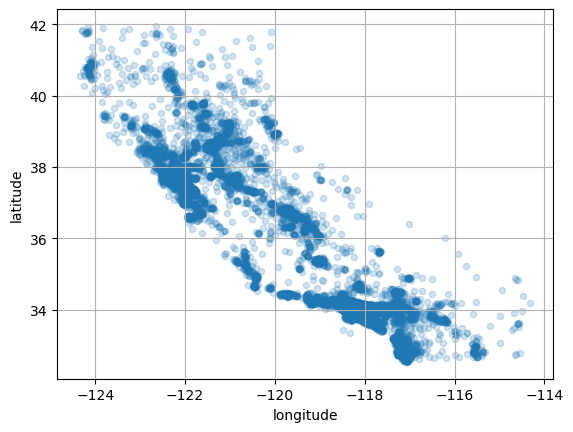

In [16]:
strat_train_set.plot.scatter(
    x="longitude",
    y="latitude",
    grid=True,
    alpha=.2 # set the transperancy of each dot
    # to see the density of data
)

- Embed more info into graphics:
  - Dot Radius represents distric's poputation
  - Color represent price

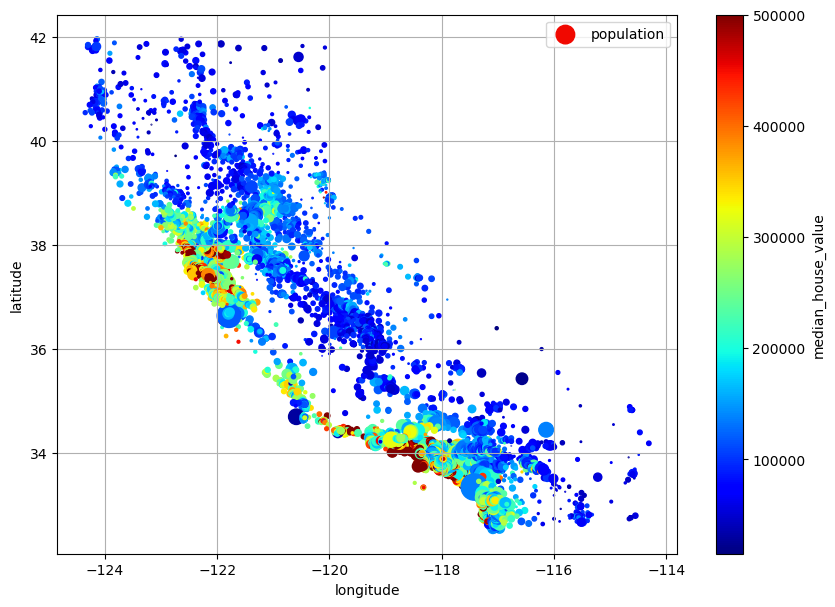

In [17]:
data.plot.scatter(
    x="longitude",
    y="latitude",
    grid=True,
    s=data["population"]/100, # size of each marker
    label = "population",
    c="median_house_value", # column to color-map to
    cmap="jet", # type of color map
    colorbar=True,
    legend=True,
    figsize=(10,7)
)

plt.show()

### 2. Look for correlations

- Calculate pearson coeff of every pair of attribute
  - pearson is for **linear relationship**, and for vars that adhear to the **normal distribution**


In [18]:
corr_matrix = data.corr(numeric_only=True)

In [19]:
corr_matrix["median_house_value"].sort_values()

latitude             -0.144160
longitude            -0.045967
population           -0.024650
total_bedrooms        0.049686
households            0.065843
housing_median_age    0.105623
total_rooms           0.134153
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

=> **median_income** seams to be the most influential to the **median_house_value**

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

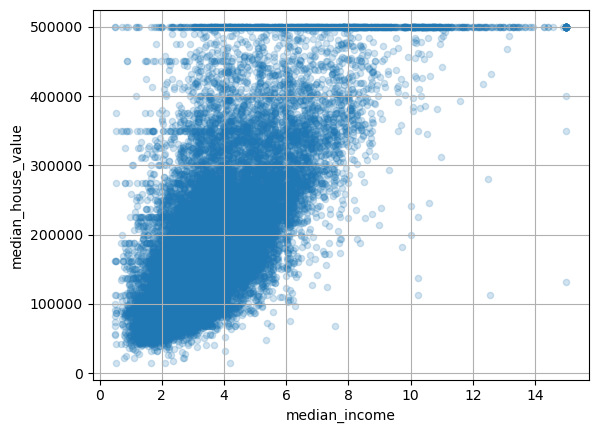

In [20]:
data.plot.scatter(
    y="median_house_value",
    x="median_income",
    alpha=.2,
    grid=True
)

- Outliers are values 
  - Shorter period of time
  - Unpredictable
- Data quirks are patterns
  - Longer period of time
  - More predictable  

==> REMOVE the data quirks in `median_house_value` values: ~45k, ~35k, ~28k, ~23k, etc.  

### 3. Experiment with attribute combinations
- trying to create **new attributes** with **higher correlation coefficient** with the target column (*median_house_value*)  

In [21]:
# new attributes created
data["rooms_per_house"] = data["total_rooms"] / data["households"]
data["bedrooms_per_house"] = data["total_bedrooms"] / data["households"]
data["people_per_house"] = data["population"] / data["households"]

In [22]:
## checking corr on the new attributes created
corr_matrix=data.corr(numeric_only=True)

In [23]:
corr_matrix["median_house_value"].sort_values(ascending=True)

latitude             -0.144160
bedrooms_per_house   -0.046739
longitude            -0.045967
population           -0.024650
people_per_house     -0.023737
total_bedrooms        0.049686
households            0.065843
housing_median_age    0.105623
total_rooms           0.134153
rooms_per_house       0.151948
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

## IV. Prepare data for ML Algo

In [24]:
# revert to training set 
## remove the lables
data = strat_train_set.drop("median_house_value", axis=1)
data_lables = strat_train_set["median_house_value"].copy()

### Clean

#### 1. Null numerical values:
  - **Imputation**: replace with other values:
    - *numerical*: 0, 1, mean, median
    - *non-numerical*: most frequent values, constant
  - *remove* record
  - *remove* the atributes

In [25]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
'''
SimpleImputer(strategy="mean")

- Greate for non-numerical data
SimpleImputer(strategy="constant", fill_value="dummy_string")
SimpleImputer(strategy="most_frequent")
'''

'\nSimpleImputer(strategy="mean")\n\n- Greate for non-numerical data\nSimpleImputer(strategy="constant", fill_value="dummy_string")\nSimpleImputer(strategy="most_frequent")\n'

In [26]:
# SimpleImputer can only calculate on the numerical columns
data_numerical = data.select_dtypes(include=[ np.number ])

In [27]:
'''
Using the estimator to compute somthing from a dataset
'''
imputer.fit(data_numerical)

SimpleImputer(strategy='median')

In [28]:
'''
you can access an sklearn estimator's computed fields,
using the variables with the underscore suffix 
'''
imputer.statistics_ # show median calculated

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [29]:
'''
Apply the computed variables of the estimator on a dataset

Note: all functions in sklearn only return values of type numpy array,
    or scipy sparse matrix 
'''
X = imputer.transform(data_numerical)

In [30]:
# turning the numpy array into the original dataframe 
data_numerical_imputed=pd.DataFrame(
    X, columns=data_numerical.columns, index=data_numerical.index)

In [31]:
data_numerical_imputed

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


#### 2. Text and categorical Attributes
- **Ordinal Encoding**: Turn into numbers, if it infer a spectrum or level of something, E.g:
  - steel, gold, diamond => 0,1,2
  - very far, far, near, adjacent => 3,2,1,0
  - etc.
- **One-hot Encoding**: Turn into multiple dummy boolean columns, E.g:  
  |a|b|
  |-|-|
  |1|fish|    
  |2|meat|
  |3|egg| 
   
  turn into:    
    |a|fish|meat|egg
    |-|-|-|-|
    |1|1|0|0|    
    |2|0|1|0|
    |3|0|0|1|

In [32]:
from sklearn.preprocessing import (
    OneHotEncoder, # turn categorical data into many dummy boolean columns
    OrdinalEncoder # turn categorical data into an array of numbers
    ) 

In [33]:
data_cat = data[["ocean_proximity"]]

In [34]:
ordinal_encoder = OrdinalEncoder()
data_cat_encoded = ordinal_encoder.fit_transform(data_cat)
# the text category has been changed into numbers
display(data_cat_encoded[:5])
display(ordinal_encoder.categories_)

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.]])

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [35]:
one_hot_encoder = OneHotEncoder(
    sparse_output=True, # get scipy sparse matrix as output
    handle_unknown="ignore" # dont raise exeption when encounter new category in transform()
    )
data_cat_1hot = one_hot_encoder.fit_transform(data_cat)
display(data_cat_1hot)
display(one_hot_encoder.categories_)

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [36]:
display(one_hot_encoder.feature_names_in_)
display(one_hot_encoder.get_feature_names_out())

array(['ocean_proximity'], dtype=object)

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

** Note:
When there're **too many categories**
  - replace with **representative numerical value**, E.g.: 
    - instead of *country name*, replace it with *country population*
    - etc.
  - **Embedding**: represent the category by a low dimensional matrix

### Feature Scaling and Transformation

#### 1.Common scaling
* **Types** of scaling:
  - **Normalization** (min max scaling):
    - Sensitive to **outliers**
    - Suitable to stable features like *ages*, (**not stable** like *income*)
    - Can put data into any range of values => **prefered by Neural Networks**
  - **Standadization**
    - Unsensitive to outliers
    - standard deviation is always 1 
    - mean is 0 
  - **Logarithm Scaling**
    - Suitable for **heavily skewed distribution** (like **power-law** distribution)
  - **Bucketizing** (put data into bins)
    - for:
      -  **heavily skewed distribution**
      -  **multimodal distribution** (need **Encoding** after butketized)
* **Quantiative criterias** for choosing Scaling systems:
  - Skewness ?
  - Standard deviation ?
  - Usage of data (into a **neural network** or not) ?
  - Multimodal ? 

In [37]:
from sklearn.preprocessing import MinMaxScaler

# E.g.: Neural network prefer zero-mean features scaling
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
data_numerical_min_max_scaled = min_max_scaler.fit_transform(data_numerical)

In [38]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
data_numerical_std_scaled = standard_scaler.fit_transform(data_numerical)

standard_scaler.get_feature_names_out()

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

#### 2.Dealing with multimodal distribution with RBF
* **RBF** (*radial basis function*) 
  - **Gaussian RBF** measure similarity between **2 values, x and y**in this case
    ```
    exp(–γ(x – y)²)
    ```
    - `(x-y)²` is the distance of the 2 vectors. (1D,2D,..) 
  - the hyperparameter **Gamma 'γ'** determine how quickly the **similarity decay** when the value **'x' changes**
* **Gausian RBF** turns the **multimodal distr** into **Gausian shaped distr**

In [39]:
# measuring the similarity between the housing median age and 35
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(
    data[["housing_median_age"]],
    [[35]],
    gamma=.1
    )
age_simil_35

array([[2.73237224e-02],
       [8.93948745e-35],
       [3.03539138e-04],
       ...,
       [4.57533877e-08],
       [7.04065961e-20],
       [1.66155727e-03]])

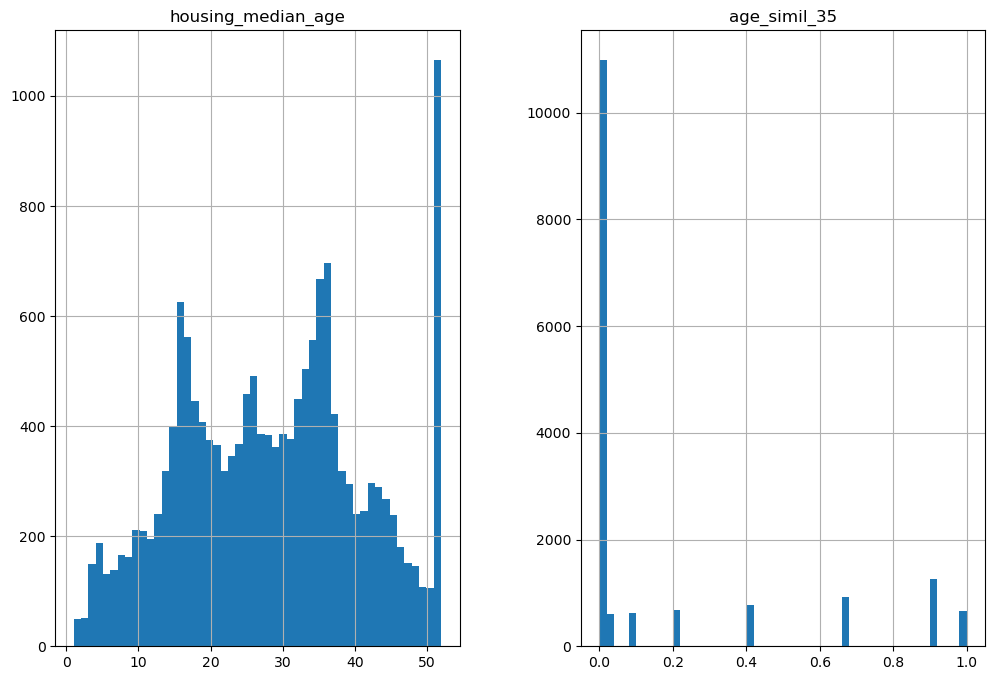

In [40]:
# compare age_simil_35 to data["housing_median_age"]
rbf_compare = data[["housing_median_age"]].copy()
rbf_compare["age_simil_35"] = age_simil_35
rbf_compare.hist(bins=50, figsize=(12, 8))

plt.show()

#### 3.Transform the target `median_house_value`
- Note: when the model predicts **relationship** between the **features** and **labels**, but the **labels** has been **tranformed**, you can use the function `inverse_transform()` to get the labels back!!!

1. **Create** and use the **StandardScaler** to **transform** the `data_labels`

In [41]:
from sklearn.linear_model import LinearRegression

labels_scaler = StandardScaler()
scaled_lables =  labels_scaler.fit_transform(
    data_lables.to_frame()) # StandardScaler takes in pandas DataFrame, not Series

2. **Create** and use the estimator **LinearRegression** to make a `model`

In [42]:
model = LinearRegression()
model.fit(data[["median_income"]], scaled_lables)
some_new_data = data[["median_income"]].iloc[:5] # lets pretend this is new data

3. **Test the model** to get prediction from the `some_new_data`

In [43]:
scaled_predictions = model.predict(some_new_data)
predictions = labels_scaler.inverse_transform(scaled_predictions)
predictions

array([[135958.75805364],
       [309735.008975  ],
       [165232.3998617 ],
       [138162.41971241],
       [232903.1766333 ]])

4. Instead of calling **scaler** and **linear model** sepearately, we can use `TransformedTargetRegressor` 

In [44]:
from sklearn.compose import TransformedTargetRegressor

model=TransformedTargetRegressor(
    LinearRegression(), # parse the model maker
    transformer=StandardScaler() # parse the transformer (a scaler in this case)
)
model.fit(data[["median_income"]], data_lables)
display(model.predict(some_new_data))

array([135958.75805364, 309735.008975  , 165232.3998617 , 138162.41971241,
       232903.1766333 ])

### Custom Transformers

#### 1. Basics
- for transformer that **doesn't require any training**, the **input and ouput** should be **numpy arrays**
- The functions of the transformer will be **numpy functions**

In [45]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(
    np.log,
    inverse_func=np.exp # needed when the transformer is used by a TransformedTargetRegressor
)

log_pop=log_transformer.transform(data["population"])
log_pop

12655    7.712891
15502    7.608374
2908     6.502790
14053    6.800170
20496    7.515889
           ...   
15174    7.613819
12661    8.469892
19263    6.126869
19140    7.096721
19773    6.437752
Name: population, Length: 16512, dtype: float64

- FunctionTransformer can also takein arguments of the parsed function 

In [46]:
rbf_transformer = FunctionTransformer(
    rbf_kernel,
    kw_args=dict( Y=[[35.]], gamma=.1 )
)

- Apply the `rbf_transformer` on `housing_median_age`

In [47]:
age_simil_35=rbf_transformer.transform(data[["housing_median_age"]])
age_simil_35

array([[2.73237224e-02],
       [8.93948745e-35],
       [3.03539138e-04],
       ...,
       [4.57533877e-08],
       [7.04065961e-20],
       [1.66155727e-03]])

- **Note**: `Gausian Radial Basis Function` only measure the `distance` between 2 vectors, we **dont know** how many dimensions the vectors have  
=> `rbf_kernel` doesn't have a `inverse_func`

- Apply `rbf_kernel` on *2D vectors* (`np.array`), measure the similarity of district to **San Francisco**

In [48]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(
    rbf_kernel,
    kw_args=dict(Y=[sf_coords], gamma=.1)
)

df_simil=sf_transformer.transform(data[["latitude","longitude"]])
df_simil

array([[0.86435873],
       [0.0076117 ],
       [0.18013578],
       ...,
       [0.94757821],
       [0.9636345 ],
       [0.61315569]])

#### 2. Full fledge custom **Estimator**
- with `fit()` and `fit_transform()` functions
- `fit()` function must return `self` (which might be the **trained model**)

a. **StandardScaler Clone**

In [49]:
from typing import  Union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(
    BaseEstimator, # add 2 methods get_params() and set_params()
    TransformerMixin # add fit_transform() after fit() and tranform() have been defined
    ):

    def __init__(self, with_mean=True) -> None:
        # no args or kwargs => be explicit
        self.with_mean= with_mean

    def fit(self,
            X:Union[np.array,pd.DataFrame],
            y:np.array=None): # a fit function must contains X and y arguments
        X = check_array(X) # check if X is non emtpy 2D array, with finite float values
        self.mean_=X.mean(axis=0) # learned variables have trailing underslash
        self.scale_=X.std(axis=0)
        self.n_features_in_=X.shape[1] # every estimator stores this in fit()
        if type(X) == pd.DataFrame:
            self.feature_names_in_=X.columns.to_numpy()
        return self # !!!always return self

    def transform(self, X) -> np.array:
        check_is_fitted(self) # looks for `learned attributes` (with trailing underslash)
        X = check_array(X)

        assert self.n_features_in_ == X.shape[1] # check if the parsed data is aligned with the learned attributes
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
    
    def get_feature_names_out(self,
                              names=None # must contains names
                              ) -> np.array:
        check_is_fitted(self)
        if hasattr(self,"feature_names_in_"):
            return self.feature_names_in_
        else:
            return np.arange(self.n_features_in_)

b. Custom Estimator that integrate **other Estimator**
- Create a `ClusterSimilarity`:
  - **KMeans clustering** to find the **centers** that are the highest `median_house_value`
  - Use **Gaussian RBF** to measure the similarities

In [54]:
from sklearn.cluster import  KMeans

class ClusterSimilarity(
    BaseEstimator, # give get_params() and set_params()
    TransformerMixin # fit_transform()
    ):
    def __init__(self,
                 n_clusters:int=10, # number of clusters
                 random_state:int=None, # decide the random starting points of the centers 
                 gamma:float=.1, # decay factor,
                 n_init: int=10
                 ) -> None:
        self.n_clusters=n_clusters
        self.random_state=random_state
        self.gamma=gamma
        self.n_init=n_init

    def fit(self,
            X,
            y=None,
            sample_weight:float=None):
        check_array(X)
        self.kmeans_= KMeans(
            n_clusters=self.n_clusters,
            random_state=self.random_state,
            n_init=self.n_init)
        self.kmeans_.fit(X=X, sample_weight=sample_weight)

        # take advantages of the initialized variables in self.kmeans_
        self.n_features_in_ = self.kmeans_.n_features_in_
        if type(X) == pd.DataFrame:
            self.feature_names_in_=self.kmeans_.feature_names_in_
        return self
    
    def transform(self,X):
        check_is_fitted(self)
        assert X.shape[1] == self.n_features_in_ , "input must have the same number of features"
        return rbf_kernel(X=X, Y = self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        check_is_fitted(self)
        return self.feature_names_in_

- Implement the custom transformer `ClusterSimilarity` on the **longitude** and **latitude** columns

In [72]:
cluster_simil = ClusterSimilarity(
    n_clusters=10,
    random_state=42,
    gamma=1.5,
    n_init=20
)
similarities = cluster_simil.fit_transform(
    data[['latitude','longitude']],
    sample_weight=data_lables
)

- Show the `trained data` on the scatter plot
  - ***Tip**: try changing the `gamma` param of the `cluster_simil` to see the **different results** on the scatter plot

In [76]:
'''
try execute the below code to understand why should you use .max(axis=1)
data["cluster_similarity"] = similarities
'''
data["cluster_similarity"] = similarities.max(axis=1)

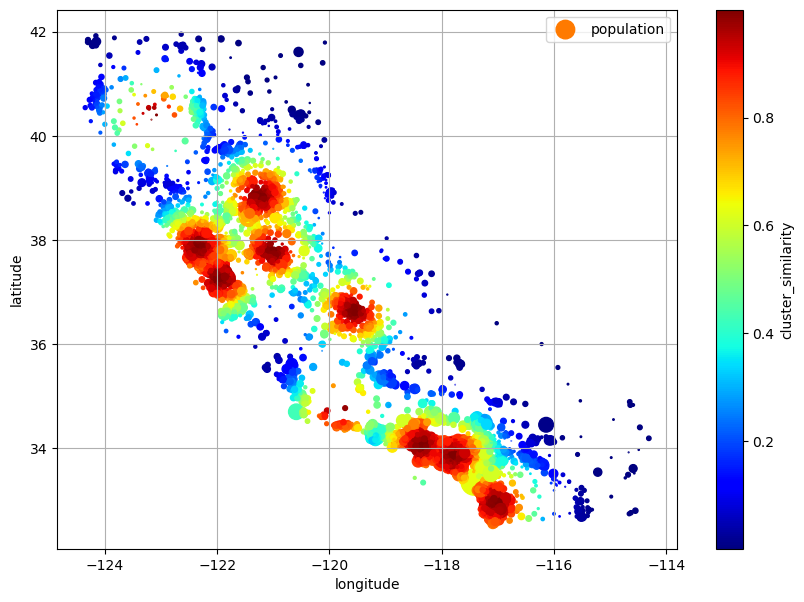

In [74]:
data.plot.scatter(
    x="longitude",
    y="latitude",
    grid=True,
    s=data["population"]/100, # size of each marker
    label = "population",
    c="cluster_similarity", # column to color-map to
    cmap="jet", # type of color map
    colorbar=True,
    legend=True,
    figsize=(10,7)
)

plt.show()

In [ ]:
data.drop(columns=["cluster_similarity"], inplace=True)

### Transformation Pipelines

#### a. basics of Pipline and demonstration on numerial data

- a more advanced `FunctionTransformer`
- allow chaining multiple **sklearn estimators**
- **Pipeline()**:
  -  param is a **list of sets** `(<name>, <transformer>)`
  -  Except fot the last estimator, it can **transformer or not**,
  -  names can't have **underslash "_"** in them 
  -  Pipeline exposed **the same methods** of the **last estimator**
     -  when call `fit()`, **Pipline** will execute `fit_transform()` on every steps, then the **fit()** at the last step
-  ***Tip**: code below to view the **estimators/piplines** as digram in each **notebook cell**
    ```python
    sklearn.set_config(display="diagram")
    ```

In [83]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("standardize", StandardScaler())
])

- when you dont want to specify the names of the transformers, use `make_pipline()` instead
  -   the names will be the name of the transformer itself, but lowecase

In [87]:
from sklearn.pipeline import make_pipeline

num_pipeline=make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

In [101]:
data_num_prepared = num_pipeline.fit_transform(data_numerical)
df_data_num_prepared = pd.DataFrame(
    data_num_prepared,
    columns=num_pipeline.get_feature_names_out()
)

- Pipline supports **indexing**, you can call the **name of the step**, of the **index of the step**

In [100]:
display(num_pipeline['simpleimputer'])
display(num_pipeline[0])

SimpleImputer(strategy='median')

SimpleImputer(strategy='median')

#### b. a Pipline to handle both **text** and **numerial** columns

In [113]:
from sklearn.compose import ColumnTransformer

num_attribs = [
    "longitude", "latitude", "housing_median_age", "total_rooms",
    "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs), # <unique name>, <transformer>, <list of columns(s)>
    ("cat", cat_pipline, cat_attribs)
])

- `make_column_selector()` selects columns based on types
- `make_column_transformer()` create ColumnTransformer without specifying names

In [118]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipline, make_column_selector(dtype_include=object))
)

#### c. Apply all pipelines on the data 

In [127]:
data_prepared = preprocessing.fit_transform(data)

In [129]:
df_data_prepared = pd.DataFrame(
    data_prepared,
    columns=preprocessing.get_feature_names_out()
)